In [ ]:
!pip install scikit-learn==1.4.2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import joblib

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/NF-UQ-NIDS.csv')
data = pd.DataFrame(data)
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,Dataset
0,149.171.126.0,62073,59.166.0.5,56082,6,0.000,9672,416,11,8,25,15,0,Benign,NF-UNSW-NB15
1,149.171.126.2,32284,59.166.0.5,1526,6,0.000,1776,104,6,2,25,0,0,Benign,NF-UNSW-NB15
2,149.171.126.0,21,59.166.0.1,21971,6,1.000,1842,1236,26,22,25,1111,0,Benign,NF-UNSW-NB15
3,59.166.0.1,23800,149.171.126.0,46893,6,0.000,528,8824,10,12,27,124,0,Benign,NF-UNSW-NB15
4,59.166.0.5,63062,149.171.126.2,21,6,1.000,1786,2340,32,34,25,1459,0,Benign,NF-UNSW-NB15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994888,192.168.100.46,80,192.168.100.5,80,6,7.000,2330065,0,2523,0,0,4263037,0,Benign,NF-BoT-IoT
11994889,192.168.100.5,0,192.168.100.3,0,6,0.000,1054423,0,1513,0,0,4263062,0,Benign,NF-BoT-IoT
11994890,192.168.100.7,365,192.168.100.3,565,17,0.000,62422,0,1357,0,0,4263062,0,Benign,NF-BoT-IoT
11994891,192.168.100.3,50850,13.54.166.67,8883,6,222.178,11300,1664,32,32,24,4264935,0,Benign,NF-BoT-IoT


In [ ]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11994893 entries, 0 to 11994892
Data columns (total 15 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   IPV4_SRC_ADDR               object 
 1   L4_SRC_PORT                 int64  
 2   IPV4_DST_ADDR               object 
 3   L4_DST_PORT                 int64  
 4   PROTOCOL                    int64  
 5   L7_PROTO                    float64
 6   IN_BYTES                    int64  
 7   OUT_BYTES                   int64  
 8   IN_PKTS                     int64  
 9   OUT_PKTS                    int64  
 10  TCP_FLAGS                   int64  
 11  FLOW_DURATION_MILLISECONDS  int64  
 12  Label                       int64  
 13  Attack                      object 
 14  Dataset                     object 
dtypes: float64(1), int64(10), object(4)
memory usage: 1.3+ GB


In [ ]:
data=data.drop(['Dataset'],axis=1)
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11994893 entries, 0 to 11994892
Data columns (total 14 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   IPV4_SRC_ADDR               object 
 1   L4_SRC_PORT                 int64  
 2   IPV4_DST_ADDR               object 
 3   L4_DST_PORT                 int64  
 4   PROTOCOL                    int64  
 5   L7_PROTO                    float64
 6   IN_BYTES                    int64  
 7   OUT_BYTES                   int64  
 8   IN_PKTS                     int64  
 9   OUT_PKTS                    int64  
 10  TCP_FLAGS                   int64  
 11  FLOW_DURATION_MILLISECONDS  int64  
 12  Label                       int64  
 13  Attack                      object 
dtypes: float64(1), int64(10), object(3)
memory usage: 1.3+ GB


In [ ]:
data.isnull().sum()

IPV4_SRC_ADDR                 0
L4_SRC_PORT                   0
IPV4_DST_ADDR                 0
L4_DST_PORT                   0
PROTOCOL                      0
L7_PROTO                      0
IN_BYTES                      0
OUT_BYTES                     0
IN_PKTS                       0
OUT_PKTS                      0
TCP_FLAGS                     0
FLOW_DURATION_MILLISECONDS    0
Label                         0
Attack                        0
dtype: int64

In [ ]:
count = data.Attack.value_counts()
percentages = data['Attack'].value_counts(normalize=True) * 100
print("Counts:\n", count)
print("\nPercentages:\n", percentages)

Counts:
 Attack
Benign            9208048
DDoS               763285
Reconnaissance     482946
injection          468575
DoS                348962
Brute Force        291955
password           156299
xss                 99944
Infilteration       62072
Exploits            24736
scanning            21467
Fuzzers             19463
Backdoor            19029
Bot                 15683
Generic              5570
Analysis             1995
Theft                1909
Shellcode            1365
mitm                 1295
Worms                 153
ransomware            142
Name: count, dtype: int64

Percentages:
 Attack
Benign            76.766404
DDoS               6.363416
Reconnaissance     4.026264
injection          3.906454
DoS                2.909255
Brute Force        2.433994
password           1.303046
xss                0.833221
Infilteration      0.517487
Exploits           0.206221
scanning           0.178968
Fuzzers            0.162261
Backdoor           0.158643
Bot                0.13074

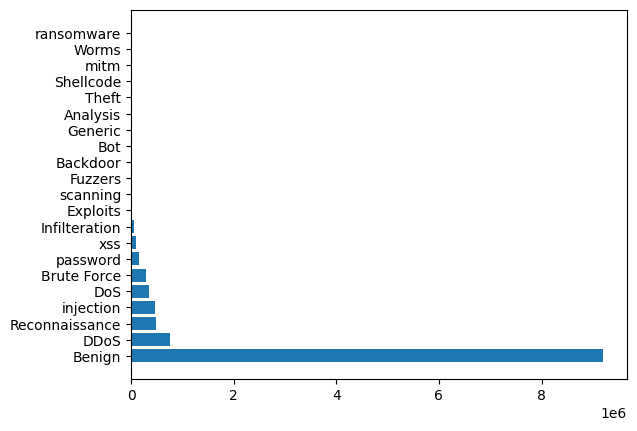

In [ ]:
plt.barh(count.index,count)
plt.show()

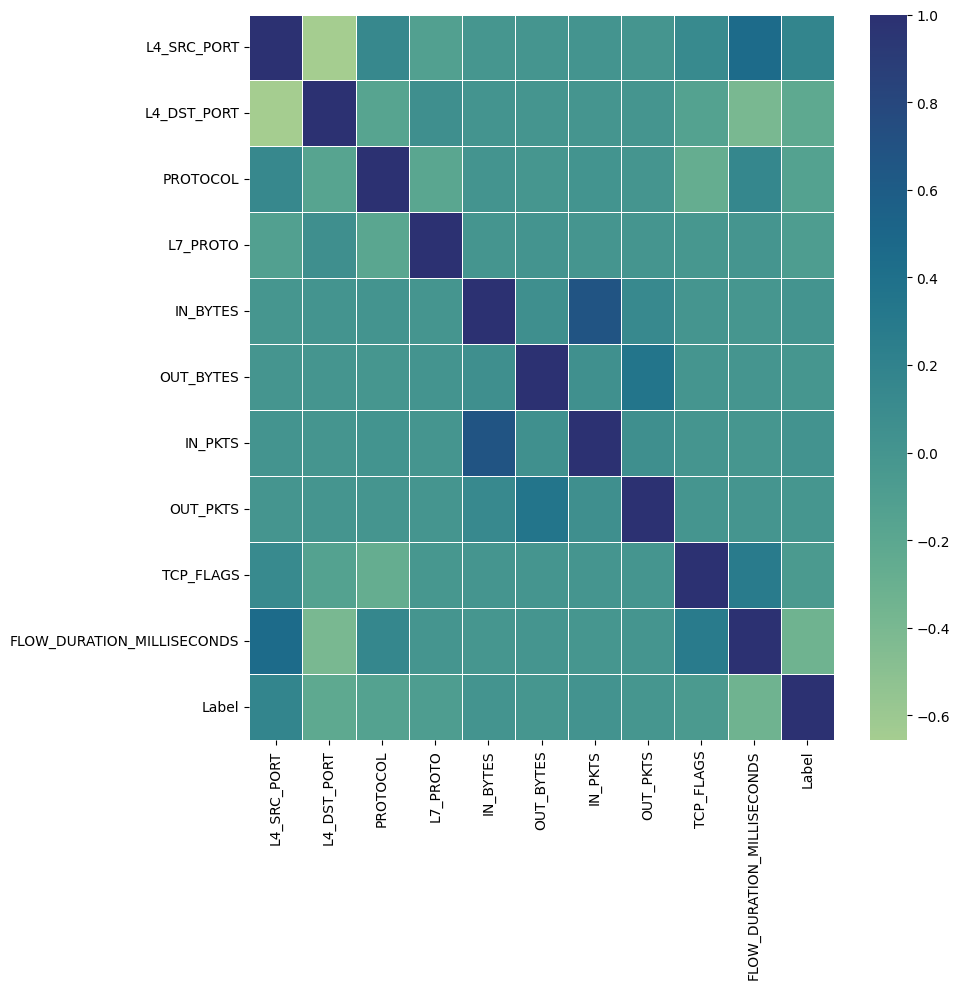

In [ ]:
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, linewidths=.5, cmap="crest")
plt.tight_layout()
plt.show()

In [ ]:
label_encoder = LabelEncoder()
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                df[col] = label_encoder.fit_transform(df[col])

le(data)
data.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,18035,62073,25333,56082,6,0.0,9672,416,11,8,25,15,0,2
1,18047,32284,25333,1526,6,0.0,1776,104,6,2,25,0,0,2
2,18035,21,25329,21971,6,1.0,1842,1236,26,22,25,1111,0,2
3,64615,23800,5246,46893,6,0.0,528,8824,10,12,27,124,0,2
4,64619,63062,5258,21,6,1.0,1786,2340,32,34,25,1459,0,2


In [ ]:
X = data.drop(['Label','Attack'],axis=1)
y = data['Label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.head()


,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS
4817595,21201,55637,6626,53,17,0.000,122,193,2,2,0,0
5763255,21203,55604,19944,443,6,91.178,942,6219,10,10,218,4294829
8230100,21022,50884,5542,443,6,0.000,2938,779,9,9,218,4294565
9931989,27630,51661,6902,80,6,0.000,232,0,5,0,222,0
5517214,21013,49981,333,443,6,0.000,332,403,6,7,29,4291830


In [ ]:
models = [DecisionTreeClassifier,LogisticRegression,GaussianNB]
accuracy_test=[]
for m in models:
    print(f'\nModel Name:')
    print(str(m),'\n')
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('\nTest Accuracy \n')
    print(acc,'\n')
    print('\nConfusion_matrix \n')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()


Model Name:
<class 'sklearn.tree._classes.DecisionTreeClassifier'> 



In [ ]:
classifier=DecisionTreeClassifier()
classifier.fit(X_train, y_train)
pred = classifier.predict(X_test)
acc = accuracy_score(pred, y_test)

In [ ]:
print('Accuracy : ',(acc*100))
print(classification_report(y_test, pred))

Accuracy :  99.45335077964418
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1840783
           1       0.99      0.99      0.99    558196

    accuracy                           0.99   2398979
   macro avg       0.99      0.99      0.99   2398979
weighted avg       0.99      0.99      0.99   2398979



In [ ]:
import joblib
joblib.dump(classifier, 'DT_malacious_traffic_classifier.pkl',compress=9)

['DT_malacious_traffic_classifier.pkl']

192.168.23.45
22
192.34.56.22
22
6
0.0000
54
6545
656
676
76
66
[0]


In [ ]:
!pip install psutil joblib


In [ ]:
import psutil
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder
import time
def get_process_network_io(pid):
    try:
        process = psutil.Process(pid)
        connections = process.connections(kind='inet')

        total_in_bytes = 0
        total_out_bytes = 0
        total_in_packets = 0
        total_out_packets = 0
        details = []

        for conn in connections:
            if conn.status == psutil.CONN_ESTABLISHED:
                if conn.raddr:
                    total_out_bytes += conn.nbytes_sent if hasattr(conn, 'nbytes_sent') else 0
                    total_out_packets += conn.packets_sent if hasattr(conn, 'packets_sent') else 0
                    details.append({
                        'IPV4_SRC_ADDR': conn.laddr.ip,
                        'L4_SRC_PORT': conn.laddr.port,
                        'IPV4_DST_ADDR': conn.raddr.ip,
                        'L4_DST_PORT': conn.raddr.port,
                        'PROTOCOL': conn.type,
                        'TCP_FLAGS': 0,
                        'FLOW_DURATION_MILLISECONDS': 0
                    })
                else:
                    total_in_bytes += conn.nbytes_recv if hasattr(conn, 'nbytes_recv') else 0
                    total_in_packets += conn.packets_recv if hasattr(conn, 'packets_recv') else 0
                    details.append({
                        'IPV4_SRC_ADDR': conn.raddr.ip if conn.raddr else 'unknown',
                        'L4_SRC_PORT': conn.raddr.port if conn.raddr else 0,
                        'IPV4_DST_ADDR': conn.laddr.ip,
                        'L4_DST_PORT': conn.laddr.port,
                        'PROTOCOL': conn.type,
                        'TCP_FLAGS': 0,
                        'FLOW_DURATION_MILLISECONDS': 0
                    })

        return {
            'in_bytes': total_in_bytes,
            'out_bytes': total_out_bytes,
            'in_packets': total_in_packets,
            'out_packets': total_out_packets,
            'details': details
        }

    except psutil.NoSuchProcess:
        print(f"No process found with PID {pid}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


def process_input(data):
    df = pd.DataFrame(data)

    label_encoder = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = label_encoder.fit_transform(df[col])

    model = joblib.load('DT_malacious_traffic_classifier.pkl')
    pred = model.predict(df)
    print(f"Prediction: {pred}")

def main():
    pid = int(input("Enter the PID of the process: "))

    while True:
        network_io = get_process_network_io(pid)
        if network_io and network_io['details']:
            for detail in network_io['details']:
                process_input([[
                    detail['IPV4_SRC_ADDR'],
                    detail['L4_SRC_PORT'],
                    detail['IPV4_DST_ADDR'],
                    detail['L4_DST_PORT'],
                    detail['PROTOCOL'],
                    0,
                    network_io['in_bytes'],
                    network_io['out_bytes'],
                    network_io['in_packets'],
                    network_io['out_packets'],
                    detail['TCP_FLAGS'],
                    detail['FLOW_DURATION_MILLISECONDS']
                ]])
        else:
            print("No network I/O data available.")

        time.sleep(5)

if __name__ == "__main__":
    main()


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-f7e822fe2210>", line 99, in <cell line: 98>
    main()
  File "<ipython-input-20-f7e822fe2210>", line 73, in main
    pid = int(input("Enter the PID of the process: "))
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 851, in raw_input
    return self._input_request(str(prompt),
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 895, in _input_request
    raise KeyboardInterrupt("Interrupted by user") from None
KeyboardInterrupt: Interrupted by user

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError

TypeError: object of type 'NoneType' has no len()